# Deconvolution
Mean combined, telescope and unresolved corrected data

Correction for PSF smearing will be after!

16.08.2024 - I do not use boundary condition any more and use the cutted version of the PSF as it allows to avoid niases caused by detector features in the PSF image that are not part of the actual star image. I also use a region of 112 pixels (~400 mas) from the center to calculate difference between iterations 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits

from scipy.signal import convolve2d
from scipy.signal import convolve, oaconvolve
from PIL import Image, ImageChops
from astropy.convolution import convolve_fft

import sys

## Functions

In [2]:
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*1/rng #normalised to [0,1]

def compare(img1, img2):
    # normalize to compensate for exposure difference

    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))/np.sum(img1)

    return m_norm


def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(dir,qfile)
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):

            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]

    return image, n

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n




def plotImage(image, lim):
    n = image.shape[0]

    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for IRDIS
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

In [3]:
from scipy.ndimage import rotate

## Star Set up

In [14]:
#dirdat = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/'
#fig_folder= '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/'

stars=['02.SCI_AR_Pup','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya']
stars=['01.SCI_AR_Pup']

#stars = ['IRAS08544-4431','IRAS08544-4431_dc_notnorm','UMon']


stars_type={'HD83878':'ref','IRAS08544-4431_dc_notnorm':'sci','REF_HD75885':'ref', '01.SCI_AR_Pup':'sci','UMon':'sci','UMon_Katya':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','HD71253':'ref','HD94680':'ref','HD96314':'ref','HD98025':'ref','V709_Car':'sci','HR4226':'sci'}
#ref_of_sci={'AR_Pup_dc_notnorm':'HD75885','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals
ref_of_sci={'01.SCI_AR_Pup':'REF_HD75885','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314','02.SCI_AR_Pup':'REF_HD74128'} #the corresponding scientific targets, SPHERE proposals

fittypes=['Q_phi']#,'Q_phi','PI']#'I','Q_phi','PI','DOLP'
#otherfittype=['I_pol']

bands=['I']
# bands=['H2','H3']
# bands = ['H3']
#if fittype!='I':
#    N_decon = 200

N_decon = 200


## Deconvolution

In [18]:
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'01.SCI_AR_Pup/'
camera = 'ZIMPOL/'

for star in stars:
    print(star)

    dirdat =dirdat0+'Unres+PSFcorr/' #'Unres+PSFcorr/' #'filtered/'

    for band in bands:

        dirName1=dirdat0+'Deconvolution_corr_tel'+'/'
        try:
        # Create target Directory
           os.mkdir(dirName1)
        except FileExistsError:
            print("Directory " , dirName1 ,  " already exists")

        dirName2=dirName1+camera+'/'
        try:
        # Create target Directory
           os.mkdir(dirName2)
        except FileExistsError:
            print("Directory " , dirName2 ,  " already exists")


        #dirName2#=dirName1 #for creating folders for the second half of deconvolution (for the u_phi and i_pol)

        for fittype in fittypes:
            critlim=0.015 #0.015

            if fittype!='I':
                critlim=0.05
            dirName=dirName2+'deconvolved_'+fittype+'/'
            try:
            # Create target Directory
               os.mkdir(dirName)
            except FileExistsError:
                print("Directory " , dirName ,  " already exists")
            image=[]
            PSF=[]
            ps=3.6
            # ps=6.8

            if fittype=='I':
                image, n=Loadimages(star,fittype,dirdat,band,'_meancombined')
            elif fittype=='PSF':
                image,n=Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' +ref_of_sci[star]+'/',band)
            else:
                # image, n=Loadimages(star,fittype,dirdat,band,'_meancombined')
                image, n=Loadimages(star,fittype,dirdat,band,'_corr_tel+unres')

            #image, n=Loadimages(star,fittype,dirdat,band,'_meancombined') #+PSF_smear
            print(ref_of_sci[star])
            PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/filtered/',band)

            print(n)

            a=int(150)#int(n/2.-20*ps)
            b=int(n-150)#int(n/2.+20*ps)
            psf=PSF[a:b,a:b]
            image=image.copy()#image[a:b,a:b],image.copy()

            x = np.linspace(-n/2., n/2., num=n)
            y = np.linspace(-n/2., n/2., num=n)
            x0 = 0.5
            y0 = 0.5
            x = x-x0
            y = y-y0
            X, Y = np.meshgrid(x, y)
            R = np.sqrt(X**2 + Y**2)

            lim=90

            rotated_image = rotate(image, 180) #180, -24.6268
            flipped_lr = np.fliplr(rotated_image)
            flipped_udlr = np.flipud(flipped_lr)

            # image = flipped_image.T
            image = flipped_udlr

            plotImage(image, lim)
            plt.savefig(dirName+ star +"_"+band+"_"+fittype+"_image.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()

            rotated_psf = rotate(psf, 180) #180, -24.6268
            flipped_psflr = np.fliplr(rotated_psf)
            flipped_psfudlr = np.fliplr(flipped_psflr)
            # # psf = flipped_psf.T
            psf = flipped_psfudlr
            # psf = rotated_psf

            plotImage(psf, lim)
            plt.savefig(dirName+star +"_"+band+ "_PSF.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()
            #adc=int(n/2.-10*ps)
            #bdc=int(n/2.+10*ps)
            psf_fliped=np.flip(psf)
            # psf_fliped=psf

            decon = np.copy(image)  # Create starting file for first iteration of deconvolution.  For the very first step, we use the original file as it’s own deconvolution
            for i in range(0, N_decon):  # now iterate
                print ('deconvolution step ' + str(i))  # just some control output

                decon = decon *(convolve_fft(image / convolve_fft(decon, psf), psf_fliped))# (convolve_fft(image / convolve_fft(decon, psf, boundary='wrap'), psf_fliped, boundary='wrap'))
                plotImage(decon, lim)

                if i<=9:
                    plt.savefig(dirName+star +"_"+band+'_0'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                else:
                    plt.savefig(dirName+star +"_"+band+'_'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                plt.close()
                if i==0:
                    deconvolved1=decon
                    crit=1

                if i>=1:
                    crit=compare(decon[a:b,a:b],deconvolved1[a:b,a:b]) #decon[a:b,a:b],deconvolved1[a:b,a:b],decon.copy(),deconvolved1.copy()
                    #crit = np.sum(ImageChops.difference(decon[adc:bdc,adc:bdc],deconvolved1[adc:bdc,adc:bdc]))/np.sum(decon[adc:bdc,adc:bdc])
                    #crit=abs(np.sum((decon[adc:bdc,adc:bdc]-deconvolved1[adc:bdc,adc:bdc])**2.)/np.sum(decon[adc:bdc,adc:bdc]**2))
                print(crit)
                deconvolved1=decon


                if fittype!='PSF':
                    if (crit<critlim):
                        N_final=i
                        break


            # This above is the implementation of the basic equation for the Richardson-Lucy deconvolution.
            # Note the np.fliplr and np.flipud functions which are required due to the quirks of numerical Fourier transformation.
            # I don’t remember the details of the specific implementation here, e.g., why I had to flip for the outer convolution but not for the inner one.
            # Probably becomes clear from a close look at the documentation of the convolve2d function.


            out_fits = fits.HDUList(fits.PrimaryHDU(decon))                  # create output fits structure
            out_fits.writeto(dirName+star+'_'+band+'_decon.fits', overwrite = True)                       # write output

01.SCI_AR_Pup
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_tel/  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL//  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL//deconvolved_Q_phi/  already exists
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/ 01.SCI_AR_Pup_I_Q_phi_corr_tel+unres.fits
01.SCI_AR_Pup_I_Q_phi_corr_tel+unres.fits
0.0
REF_HD75885
1024
1024
deconvolution step 0
1
deconvolution step 1
0.1915495530333072
deconvolution step 2
0.21319094505299616
deconvolution step 3
0.3382817446618935
deconvolution step 4
0.45870703598754214
deconvolution step 5
0.021344375969875342


In [12]:
dir_dat  = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'01.SCI_AR_Pup/filtered/'

q_mean_comb = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/01.SCI_AR_Pup/01.SCI_AR_Pup_V_Q_meancombined.fits')[0].data
u_mean_comb = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/01.SCI_AR_Pup/01.SCI_AR_Pup_V_U_meancombined.fits')[0].data
i_mean_comb = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/01.SCI_AR_Pup/01.SCI_AR_Pup_V_I_meancombined.fits')[0].data

# Avoid divide-by-zero by setting a small threshold
safe_i_mean_comb = np.where(i_mean_comb == 0, np.nan, i_mean_comb)

# Compute meancombined DoLP (use sqrt(q² + u²)/I)
dolp_mean_comb = np.sqrt(q_mean_comb**2 + u_mean_comb**2) / safe_i_mean_comb

out_fits = fits.HDUList(fits.PrimaryHDU(dolp_mean_comb))
out_fits.writeto('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/filtered/' + '01.SCI_AR_Pup_DoLP_V_meancombined.fits', overwrite=True)

In [18]:
def bin_zimpol_image(image):
    """
    Rebins a ZIMPOL image by averaging adjacent pixels in each row,
    as done in Ertel et al. (2019) to achieve 7.2 mas/pixel.
    Input image shape: (ny, nx)
    Output image shape: (ny, nx//2)
    """
    ny, nx = image.shape
    if nx % 2 != 0:
        image = image[:, :-1]  # ensure even number of columns
    binned = 0.5 * (image[:, ::2] + image[:, 1::2])
    return binned

In [ ]:
##### APPENDED FOR 2016 DI ######

In [7]:
bands = ['V']

dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'02.SCI_AR_Pup/'
camera = 'ZIMPOLv2/'

for star in stars:
    print(star)

    dirdat =dirdat0+'filtered/' #'Unres+PSFcorr/'

    for band in bands:

        dirName1=dirdat0+'Deconvolution_corr_telv1'+'/'
        try:
        # Create target Directory
           os.mkdir(dirName1)
        except FileExistsError:
            print("Directory " , dirName1 ,  " already exists")

        dirName2=dirName1+camera+'/'
        try:
        # Create target Directory
           os.mkdir(dirName2)
        except FileExistsError:
            print("Directory " , dirName2 ,  " already exists")


        #dirName2#=dirName1 #for creating folders for the second half of deconvolution (for the u_phi and i_pol)

        for fittype in fittypes:
            critlim=0.02 # 0.015

            if fittype!='I':
                critlim=0.05
            dirName=dirName2+'deconvolved_'+fittype+'/'
            try:
            # Create target Directory
               os.mkdir(dirName)
            except FileExistsError:
                print("Directory " , dirName ,  " already exists")
            image=[]
            PSF=[]
            ps=3.6
            # ps=6.8

            if fittype=='I':
                image, n=Loadimages(star,fittype,dirdat,band,'_meancombined')
            elif fittype=='PSF':
                image,n=Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' +ref_of_sci[star]+'/',band)
            else:
                # image, n=Loadimages(star,fittype,dirdat,band,'_meancombined')
                image, n=Loadimages(star,fittype,dirdat,band,'_corr_tel+unres')

            #image, n=Loadimages(star,fittype,dirdat,band,'_meancombined') #+PSF_smear
            print(ref_of_sci[star])
            PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/filtered/',band)

            a=int(440)#int(n/2.-20*ps)
            b=int(n-a)#int(n/2.+20*ps) #n-420
            psf=PSF[a:b,a:b]
            image=image[a:b,a:b]

            x = np.linspace(-n/2., n/2., num=n)
            y = np.linspace(-n/2., n/2., num=n)
            x0 = 0.5
            y0 = 0.5
            x = x-x0
            y = y-y0
            X, Y = np.meshgrid(x, y)
            R = np.sqrt(X**2 + Y**2)

            lim=100

            # uncomment for zimpol
            rotated_image = rotate(image,0) #180, -24.6268
            flipped_lr = np.fliplr(rotated_image)
            flipped_udlr = np.flipud(flipped_lr)
            image = flipped_udlr

            # image = flipped_image.T
            # image = flipped_udlr

            # plotImage(image, lim)
            plt.savefig(dirName+ star +"_"+band+"_"+fittype+"_image.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()
            #
            rotated_psf = rotate(psf, 0) #180
            flipped_psflr = np.fliplr(rotated_psf)
            flipped_psfudlr = np.fliplr(flipped_psflr)
            # psf = flipped_psf.T
            psf = flipped_psfudlr

            # plotImage(psf, lim)
            plt.savefig(dirName+star +"_"+band+ "_PSF.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()
            #adc=int(n/2.-10*ps)
            #bdc=int(n/2.+10*ps)
            psf_fliped=np.flip(psf)
            # psf_fliped=psf)

            decon = np.copy(image)  # Create starting file for first iteration of deconvolution.  For the very first step, we use the original file as it’s own deconvolution
            for i in range(0, 100):  # now iterate
                print ('deconvolution step ' + str(i))  # just some control output

                decon = decon *(convolve_fft(image / convolve_fft(decon, psf), psf_fliped))# (convolve_fft(image / convolve_fft(decon, psf, boundary='wrap'), psf_fliped, boundary='wrap'))
                plotImage(decon, lim)

                if i<=9:
                    plt.savefig(dirName+star +"_"+band+'_0'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                else:
                    plt.savefig(dirName+star +"_"+band+'_'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                plt.close()
                if i==0:
                    deconvolved1=decon
                    crit=1

                if i>=1:
                    # crit=compare(decon[a:b,a:b],deconvolved1[a:b,a:b])
                    crit=compare(decon,deconvolved1)
                    #crit = np.sum(ImageChops.difference(decon[adc:bdc,adc:bdc],deconvolved1[adc:bdc,adc:bdc]))/np.sum(decon[adc:bdc,adc:bdc])
                    #crit=abs(np.sum((decon[adc:bdc,adc:bdc]-deconvolved1[adc:bdc,adc:bdc])**2.)/np.sum(decon[adc:bdc,adc:bdc]**2))
                print(crit)
                deconvolved1=decon


                if fittype!='PSF':
                    if (crit<critlim):
                        N_final=i
                        break

            # This above is the implementation of the basic equation for the Richardson-Lucy deconvolution.
            # Note the np.fliplr and np.flipud functions which are required due to the quirks of numerical Fourier transformation.
            # I don’t remember the details of the specific implementation here, e.g., why I had to flip for the outer convolution but not for the inner one.
            # Probably becomes clear from a close look at the documentation of the convolve2d function.


            out_fits = fits.HDUList(fits.PrimaryHDU(decon))                  # create output fits structure
            out_fits.writeto(dirName+star+'_'+band+'_decon.fits', overwrite = True)                       # write output

02.SCI_AR_Pup
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2//  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2//deconvolved_I/  already exists
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/filtered/ 02.SCI_AR_Pup_V_I_meancombined.fits
02.SCI_AR_Pup_V_I_meancombined.fits
0.009975903977950415
REF_HD74128
1024
deconvolution step 0
1
deconvolution step 1
0.2988847657275871
deconvolution step 2
0.2130623097266187
deconvolution step 3
0.16069904615365815
deconvolution step 4
0.12720177215317943
deconvolution step 5
0.10451684782434623
deconvolution step 6
0.08838886537930828
deconvolution step 7
0.07645343804109958
deconvolution step 8
0.06732418282443707
deconvolution step 9
0.060148179

In [8]:
dirName

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2//deconvolved_I/'

In [16]:
def Loadimages(star, fittype, dirdat, band, extension):
    import os, fnmatch
    from astropy.io import fits
    import numpy as np

    dir = dirdat
    qfile = star + '_' + band + '_' + fittype + extension + '.fits'
    print(dir, qfile)

    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data

                # Handle 2D case
                if image.ndim == 2:
                    print("Loaded a 2D image. Expanding to 3D.")
                    image = np.expand_dims(image, axis=0)

                print(f"Loaded image shape: {image.shape}")
                n = image.shape[-1]  # Assuming square images

                return image, n

    raise FileNotFoundError(f"No file matched {qfile} in {dir}")

In [49]:
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'02.SCI_AR_Pup/'
camera = 'IRDISv4/'

bands = ['H3']

for star in stars:
    print(star)

    dirdat = dirdat0 + 'filtered/'

    for band in bands:

        dirName1 = dirdat0 + 'Deconvolution_corr_telv1' + '/'
        try:
            os.mkdir(dirName1)
        except FileExistsError:
            print("Directory", dirName1, "already exists")

        dirName2 = dirName1 + camera + '/'
        try:
            os.mkdir(dirName2)
        except FileExistsError:
            print("Directory", dirName2, "already exists")

        for fittype in fittypes:
            critlim = 0.05

            if fittype != 'I':
                critlim = 0.05

            dirName = dirName2 + 'deconvolved_' + fittype + '/'
            try:
                os.mkdir(dirName)
            except FileExistsError:
                print("Directory", dirName, "already exists")

            ps = 3.6  # plate scale


            # Load the full cube
            if fittype == 'I':
                image_cube, n = Loadimages(star, fittype, dirdat, band, '_iPCA-RDI')
                # '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/IRDIS/2016/16.0/H3_ArP2016_IRD_I.fits'
            elif fittype == 'PSF':
                image_cube, n = Loadimagespsf(ref_of_sci[star], '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' + ref_of_sci[star] + '/', band)
            else:
                image_cube, n = Loadimages(star, fittype, dirdat, band, '_corr_tel+unres')

            print(ref_of_sci[star])
            PSF, _ = Loadimagespsf(ref_of_sci[star], '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' + ref_of_sci[star] + '/filtered/', band)

            # After you load/create your psf:
            if np.sum(PSF) != 0: # Avoid division by zero if psf is truly all zeros
                PSF = PSF / np.sum(PSF)
            else:
                # Handle this case: your PSF is bad. Maybe load a default or raise an error.
                raise ValueError("PSF sum is zero. Cannot normalize for deconvolution.")

            # If psf is normalized, psf_fliped will also be normalized.
            a = int(30)
            b = int(n - a)
            psf = PSF.copy()
            # psf_fliped = np.flip(psf)

            print(image_cube.shape)
            print(psf.shape)

            # Initialize deconvolved cube container
            decon_cube = []

            # Loop through each slice in the cube
            for j in range(image_cube.shape[0]):
                print(f"Deconvolving bright slice {j + 1}/{image_cube.shape[0]}")
                image = image_cube[j]
                psf = PSF[j]

                image = image[a:b,a:b]
                psf = psf[a:b,a:b]

                # rotated_image = rotate(image, -24.6268)
                # flipped_lr = np.fliplr(rotated_image)
                # flipped_udlr = np.flipud(flipped_lr)
                # image = flipped_udlr
                #
                # rotated_psf = rotate(psf, -24.6268)
                # flipped_psflr = np.fliplr(rotated_psf)
                # flipped_psfudlr = np.fliplr(flipped_psflr)
                # psf = flipped_psfudlr
                psf_fliped = np.flip(psf)

                decon = np.copy(image)

                for i in range(20):
                    print(f'Deconvolution step {i}')
                    decon = decon * (convolve_fft(image / convolve_fft(decon, psf, allow_huge=True),
                                                  psf_fliped, allow_huge=True))
                    if i == 0:
                        deconvolved1 = decon
                        crit = 1
                    else:
                        crit = compare(decon, deconvolved1)
                        deconvolved1 = decon
                        if fittype != 'PSF' and crit < critlim:
                            break

                    # rotated_image = rotate(decon, -24.6268)
                    # flipped_lr = np.fliplr(rotated_image)
                    # flipped_udlr = np.flipud(flipped_lr)
                    # decon = flipped_udlr
                    plotImage(decon, 30)
                    plt.savefig(dirName + f"{star}_{band}_slice{i}_decon2d.png", bbox_inches='tight', pad_inches=0.1)
                    plt.close()

                rotated_image = rotate(decon, -24.6268)
                flipped_lr = np.fliplr(rotated_image)
                flipped_udlr = np.flipud(flipped_lr)
                decon = flipped_udlr

                decon_cube.append(decon)

            # Convert list to array and save as cube
            decon_cube = np.array(decon_cube)
            out_fits = fits.HDUList(fits.PrimaryHDU(decon_cube))
            out_fits.writeto(dirName + star + '_' + band + '_decon_cube.fits', overwrite=True)

            # Optional: save a few visualizations
            # lim = 50
            # for k in [0, len(decon_cube) // 2, -1]:
            #     plotImage(decon_cube[k], lim)
            #     plt.savefig(dirName + f"{star}_{band}_slice{k}_decon2d.png", bbox_inches='tight', pad_inches=0.1)
            #     plt.close()


02.SCI_AR_Pup
Directory /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ already exists
Directory /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/IRDISv4// already exists
Directory /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/IRDISv4//deconvolved_I/ already exists
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/filtered/ 02.SCI_AR_Pup_H3_I_iPCA-RDI.fits
02.SCI_AR_Pup_H3_I_iPCA-RDI.fits
39.5725045667359
REF_HD74128
1
(151, 151)
(1, 151, 151)
Deconvolving bright slice 1/151


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [55]:
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'02.SCI_AR_Pup/'
camera = 'IRDISv4/'

bands = ['H3']

for star in stars:
    print(star)

    dirdat = dirdat0 + 'filtered/'

    for band in bands:

        dirName1 = dirdat0 + 'Deconvolution_corr_telv1' + '/'
        try:
            os.mkdir(dirName1)
        except FileExistsError:
            print("Directory", dirName1, "already exists")

        dirName2 = dirName1 + camera + '/'
        try:
            os.mkdir(dirName2)
        except FileExistsError:
            print("Directory", dirName2, "already exists")

        for fittype in fittypes:
            critlim = 0.05

            if fittype != 'I':
                critlim = 0.05

            dirName = dirName2 + 'deconvolved_' + fittype + '/'
            try:
                os.mkdir(dirName)
            except FileExistsError:
                print("Directory", dirName, "already exists")

            ps = 3.6  # plate scale


            # Load the full cube
            if fittype == 'I':
                image_cube, n = Loadimages(star, fittype, dirdat, band, '_iPCA-RDI')
                # '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/IRDIS/2016/16.0/H3_ArP2016_IRD_I.fits'
            elif fittype == 'PSF':
                image_cube, n = Loadimagespsf(ref_of_sci[star], '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' + ref_of_sci[star] + '/', band)
            else:
                image_cube, n = Loadimages(star, fittype, dirdat, band, '_corr_tel+unres')

            print(ref_of_sci[star])
            PSF, _ = Loadimagespsf(ref_of_sci[star], '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' + ref_of_sci[star] + '/filtered/', band)

            # After you load/create your psf:
            if np.sum(PSF) != 0: # Avoid division by zero if psf is truly all zeros
                PSF = PSF / np.sum(PSF)
            else:
                # Handle this case: your PSF is bad. Maybe load a default or raise an error.
                raise ValueError("PSF sum is zero. Cannot normalize for deconvolution.")

            # If psf is normalized, psf_fliped will also be normalized.
            a = int(10)
            b = int(n - a)
            psf = PSF.copy()
            # psf_fliped = np.flip(psf)

            print(image_cube.shape)
            print(psf.shape)

            # Initialize deconvolved cube container
            decon_cube = []

            # Loop through each slice in the cube
            # Check if image_cube is 3D (cube) or 2D (single image)
            if image_cube.ndim == 3:
                n_slices = image_cube.shape[0]
                is_cube = True
            else:
                n_slices = 1
                is_cube = False

            # Loop over slices or treat as single image
            for j in range(n_slices):
                print(f"Deconvolving slice {j + 1}/{n_slices}")

                image = image_cube[j] if is_cube else image_cube
                psf_slice = PSF[j] if PSF.ndim == 3 else PSF

                image = image[a:b, a:b]
                psf_slice = psf_slice[a:b, a:b]

                psf_fliped = np.flip(psf_slice)
                decon = np.copy(image)

                for i in range(20):
                    print(f'Deconvolution step {i}')
                    decon = decon * (convolve_fft(image / convolve_fft(decon, psf_slice, allow_huge=True),
                                                  psf_fliped, allow_huge=True))
                    if i == 0:
                        deconvolved1 = decon
                        crit = 1
                    else:
                        crit = compare(decon, deconvolved1)
                        deconvolved1 = decon
                        if fittype != 'PSF' and crit < critlim:
                            break

                    plotImage(decon, 30)
                    plt.savefig(dirName + f"{star}_{band}_slice{i}_decon2d.png", bbox_inches='tight', pad_inches=0.1)
                    plt.close()

                rotated_image = rotate(decon, -24.6268)
                flipped_lr = np.fliplr(rotated_image)
                flipped_udlr = np.flipud(flipped_lr)
                decon = flipped_udlr

                decon_cube.append(decon)

            # Convert list to array and save as cube
            decon_cube = np.array(decon_cube)
            out_fits = fits.HDUList(fits.PrimaryHDU(decon_cube))
            out_fits.writeto(dirName + star + '_' + band + '_decon_cube.fits', overwrite=True)

            # Optional: save a few visualizations
            # lim = 50
            # for k in [0, len(decon_cube) // 2, -1]:
            #     plotImage(decon_cube[k], lim)
            #     plt.savefig(dirName + f"{star}_{band}_slice{k}_decon2d.png", bbox_inches='tight', pad_inches=0.1)
            #     plt.close()


02.SCI_AR_Pup
Directory /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ already exists
Directory /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/IRDISv4// already exists
Directory /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/IRDISv4//deconvolved_I/ already exists
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/filtered/ 02.SCI_AR_Pup_H3_I_iPCA-RDI.fits
02.SCI_AR_Pup_H3_I_iPCA-RDI.fits
39.5725045667359
REF_HD74128
1
(151, 151)
(1, 151, 151)
Deconvolving slice 1/1
Deconvolution step 0
Deconvolution step 1
Deconvolution step 2
Deconvolution step 3
Deconvolution step 4
Deconvolution step 5
Deconvolution step 6


In [ ]:
# Selected top 50% slice indices for deconvolution: [12, 47, 16, 24, 33, 31, 15, 32, 26, 25, 19, 13, 37, 42, 18, 35, 10, 36, 46, 44, 2, 20, 41, 8]

In [83]:
print(f"Sum of psf: {np.sum(PSF)}")
print(f"Sum of psf_fliped: {np.sum(psf)}")

Sum of psf: 1.000000238418579
Sum of psf_fliped: 0.0


In [11]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Load the cube
# fits_path = "/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD74128/filtered/REF_HD74128_H2_I_all.fits"
fits_path = "/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/filtered/02.SCI_AR_Pup_H3_I_all.fits"
hdul = fits.open(fits_path)
cube = hdul[0].data  # shape: (48, ny, nx)
hdul.close()

peak_i_values = [np.max(slice) for slice in cube]

# Filter for top 75% brightest
threshold = np.percentile(peak_i_values, 25)
selected_indices = [i for i, peak in enumerate(peak_i_values) if peak > threshold]
print(selected_indices)
# Mean-combine selected slices
mean_combined = np.mean(cube[selected_indices], axis=0, keepdims=True)
print(mean_combined.shape)

# Take the mean across all 48 slices (axis=0)
# mean_combined = np.mean(cube, axis=0)  # shape: (ny, nx)

# Save the result
out_path = fits_path.replace("all.fits", "meancombined.fits")
fits.writeto(out_path, mean_combined, overwrite=True)


[0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
(1, 151, 151)


In [ ]:
####### APENDED FOR 2018 ARP DATA #######

In [20]:
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+'01.SCI_AR_Pup/'
camera = 'ZIMPOLv2/'

for star in stars:
    print(star)

    dirdat =dirdat0+'filtered/' # filtered/ #Unres+PSFcorr/

    for band in bands:

        dirName1=dirdat0+'Deconvolution_corr_telv1'+'/'
        try:
        # Create target Directory
           os.mkdir(dirName1)
        except FileExistsError:
            print("Directory " , dirName1 ,  " already exists")

        dirName2=dirName1+camera+'/'
        try:
        # Create target Directory
           os.mkdir(dirName2)
        except FileExistsError:
            print("Directory " , dirName2 ,  " already exists")


        #dirName2#=dirName1 #for creating folders for the second half of deconvolution (for the u_phi and i_pol)

        for fittype in fittypes:
            critlim=0.015

            if fittype!='I':
                critlim=0.15
            dirName=dirName2+'deconvolved_'+fittype+'/'
            try:
            # Create target Directory
               os.mkdir(dirName)
            except FileExistsError:
                print("Directory " , dirName ,  " already exists")
            image=[]
            PSF=[]
            ps=3.6
            # ps=6.8

            if fittype=='I':
                dirdat = dirdat0 + 'filtered/'
                image, n=Loadimages(star,fittype,dirdat,band,'_meancombined')

            elif fittype=='DOLP':
                image = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/filtered/01.SCI_AR_Pup_DOLP_'+band+'_meancombined.fits')[0].data

                n = image.shape[-1]
            elif fittype=='PSF':
                image,n=Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/' +ref_of_sci[star]+'/',band)
            else:
                # image, n=Loadimages(star,fittype,dirdat,band,'_meancombined')
                image, n=Loadimages(star,fittype,dirdat,band,'_corr_tel+unres')

            #image, n=Loadimages(star,fittype,dirdat,band,'_meancombined') #+PSF_smear
            print(ref_of_sci[star])
            PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/filtered/',band)

            print(n)

            a=int(415)#int(n/2.-20*ps)
            b=int(n-415)#int(n/2.+20*ps)
            psf=PSF[a:b,a:b]
            image=image[a:b,a:b]

            x = np.linspace(-n/2., n/2., num=n)
            y = np.linspace(-n/2., n/2., num=n)
            x0 = 0.5
            y0 = 0.5
            x = x-x0
            y = y-y0
            X, Y = np.meshgrid(x, y)
            R = np.sqrt(X**2 + Y**2)

            lim=90

            # image = rotate(image, -24.6268) #180, -24.6268
            # flipped_lr = np.fliplr(rotated_image)
            # flipped_udlr = np.flipud(flipped_lr)
            # image = flipped_udlr

            # image = flipped_image.T
            # image = flipped_udlr

            plotImage(image, lim)
            plt.savefig(dirName+ star +"_"+band+"_"+fittype+"_image.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()

            # psf = rotate(psf, -24.6268) #180
            # flipped_psflr = np.fliplr(rotated_psf)
            # flipped_psfudlr = np.fliplr(flipped_psflr)
            # psf = flipped_psf.T
            # psf = flipped_psfudlr

            plotImage(psf, lim)
            plt.savefig(dirName+star +"_"+band+ "_PSF.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()
            #adc=int(n/2.-10*ps)
            #bdc=int(n/2.+10*ps)
            psf_fliped=np.flip(psf)

            decon = np.copy(image)  # Create starting file for first iteration of deconvolution.  For the very first step, we use the original file as it’s own deconvolution
            for i in range(0, N_decon):  # now iterate
                print ('deconvolution step ' + str(i))  # just some control output

                decon = decon *(convolve_fft(image / convolve_fft(decon, psf), psf_fliped))# (convolve_fft(image / convolve_fft(decon, psf, boundary='wrap'), psf_fliped, boundary='wrap'))
                plotImage(decon, lim)

                if i<=9:
                    plt.savefig(dirName+star +"_"+band+'_0'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                else:
                    plt.savefig(dirName+star +"_"+band+'_'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                plt.close()
                if i==0:
                    deconvolved1=decon
                    crit=1

                if i>=1:
                    # crit=compare(decon[a:b,a:b],deconvolved1[a:b,a:b])
                    crit=compare(decon,deconvolved1)
                    #crit = np.sum(ImageChops.difference(decon[adc:bdc,adc:bdc],deconvolved1[adc:bdc,adc:bdc]))/np.sum(decon[adc:bdc,adc:bdc])
                    #crit=abs(np.sum((decon[adc:bdc,adc:bdc]-deconvolved1[adc:bdc,adc:bdc])**2.)/np.sum(decon[adc:bdc,adc:bdc]**2))
                print(crit)
                deconvolved1=decon


                if fittype!='PSF':
                    if (crit<critlim):
                        N_final=i
                        break


            # This above is the implementation of the basic equation for the Richardson-Lucy deconvolution.
            # Note the np.fliplr and np.flipud functions which are required due to the quirks of numerical Fourier transformation.
            # I don’t remember the details of the specific implementation here, e.g., why I had to flip for the outer convolution but not for the inner one.
            # Probably becomes clear from a close look at the documentation of the convolve2d function.


            out_fits = fits.HDUList(fits.PrimaryHDU(decon))                  # create output fits structure
            out_fits.writeto(dirName+star+'_'+band+'_decon.fits', overwrite = True)                       # write output

01.SCI_AR_Pup
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2//  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2//deconvolved_DOLP/  already exists
REF_HD75885
1024
1024
deconvolution step 0
1
deconvolution step 1
0.13753253297718693
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2//  already exists
Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2//deconvolved_DOLP/  already exists
REF_HD75885
1024
1024
deconvolution step 0
1
deconvolution step 1
0.22

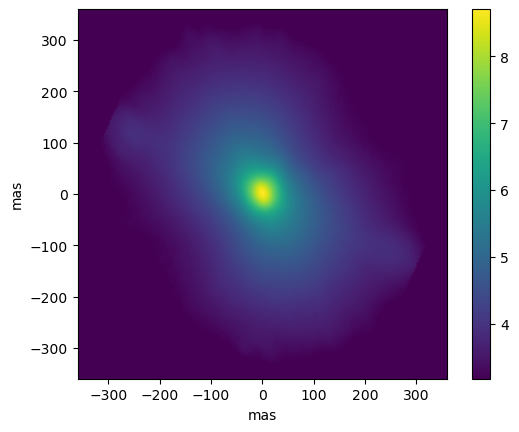

In [31]:
psf = np.fliplr(psf)
plotImage(psf, lim)

In [54]:
thedir = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL/deconvolved_I/'
thefile =  '01.SCI_AR_Pup_I_decon.fits'
with fits.open(thedir + thefile) as hdul:
    i_image = hdul[0].data
    i_n = i_image.shape[0]

In [55]:
thedir = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL/deconvolved_I/'
thefile =  '02.SCI_AR_Pup_V_decon.fits'
with fits.open(thedir + thefile) as hdul:
    v_image = hdul[0].data
    v_n = v_image.shape[0]

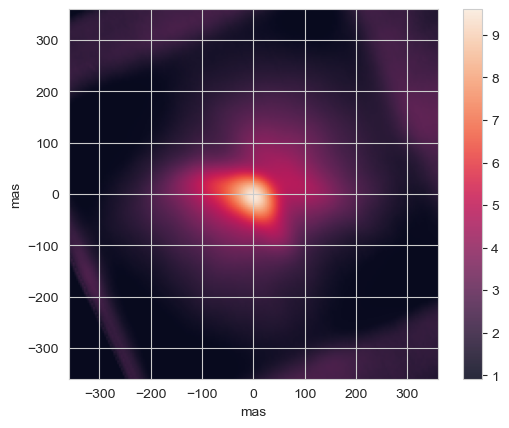

In [74]:
image = i_image
image0 = v_image
n = image.shape[0]

fig, ax = plt.subplots()
image = np.arcsinh(image)
image0 = np.arcsinh(image0)
max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
ps = 3.6 #mas per pixel for IRDIS
d = n * ps / 2
plt.imshow(image0, vmin=min, vmax=max, extent=(-d, d, d, -d), alpha=0.85)
plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d), alpha=0.85)

#plt.plot(0, 0, "+", color="red")
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas')
plt.ylabel("mas")
plt.colorbar()
plt.tight_layout

plt.savefig('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL/deconvolved_I/'+"_composite.png",bbox_inches='tight', pad_inches=0.1)

In [34]:
psf_fliped.shape

(244, 244)

In [37]:
decon.shape

(1358, 1358)